<a href="https://colab.research.google.com/github/henrychuks002/Customer-Segmentation-with-AWS/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans, MeanShift
from sklearn.mixture import GaussianMixture

%matplotlib inline
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

import plotly.io as pio
pio.renderers.default = "colab"

In [87]:
# from google.colab import files
# files.upload()

**Cleaning the Data**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
df = pd.read_excel("./gdrive/MyDrive/Colab Notebooks/Customer Segmentation/Online Retail.xlsx")
original_df = pd.DataFrame.copy(df)
df.head()

InvoiceNo StockCode  ... CustomerID         Country
0    536365    85123A  ...    17850.0  United Kingdom
1    536365     71053  ...    17850.0  United Kingdom
2    536365    84406B  ...    17850.0  United Kingdom
3    536365    84029G  ...    17850.0  United Kingdom
4    536365    84029E  ...    17850.0  United Kingdom

[5 rows x 8 columns]

In [3]:
print(df.shape)
df.info()

(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
missingv_df = df[df.isna().any(axis=1)]
missingv_df.head()

InvoiceNo StockCode  ... CustomerID         Country
622     536414     22139  ...        NaN  United Kingdom
1443    536544     21773  ...        NaN  United Kingdom
1444    536544     21774  ...        NaN  United Kingdom
1445    536544     21786  ...        NaN  United Kingdom
1446    536544     21787  ...        NaN  United Kingdom

[5 rows x 8 columns]

In [6]:
missingv_df['Country'].unique()

array(['United Kingdom', 'EIRE', 'Bahrain', 'Israel', 'Hong Kong',
       'Unspecified', 'France', 'Switzerland', 'Portugal'], dtype=object)

In [7]:
print('Total number of missing Customer ID ',missingv_df.shape[0])
for i in list(missingv_df['Country'].unique()):
    print("Total number of missing Customer ID for "+i,missingv_df[missingv_df['Country']== i].shape[0])

Total number of missing Customer ID  135080
Total number of missing Customer ID for United Kingdom 133600
Total number of missing Customer ID for EIRE 711
Total number of missing Customer ID for Bahrain 2
Total number of missing Customer ID for Israel 47
Total number of missing Customer ID for Hong Kong 288
Total number of missing Customer ID for Unspecified 202
Total number of missing Customer ID for France 66
Total number of missing Customer ID for Switzerland 125
Total number of missing Customer ID for Portugal 39


In [8]:
df.dropna(axis=0, inplace=True)
df.shape

(406829, 8)

In [9]:
df.drop_duplicates(list(df.columns), keep='first', inplace=True)
df['CustomerID'] = df['CustomerID'].astype(str)
print(df.shape)
print("Quanity columns contains some negative values {}".format(df[df['Quantity']<0].shape))
#removing negative Quantity values
drop = df[df['Quantity']<0]
index_list = list(drop.index)
df.drop(index_list, inplace=True)
df.describe()

(401604, 8)
Quanity columns contains some negative values (8872, 8)


Quantity      UnitPrice
count  392732.000000  392732.000000
mean       13.153718       3.125596
std       181.588420      22.240725
min         1.000000       0.000000
25%         2.000000       1.250000
50%         6.000000       1.950000
75%        12.000000       3.750000
max     80995.000000    8142.750000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f49467e5290>]],
      dtype=object)

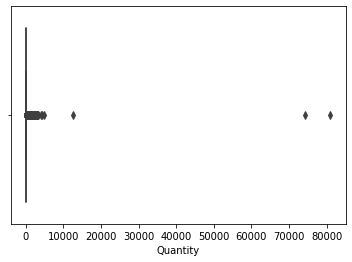

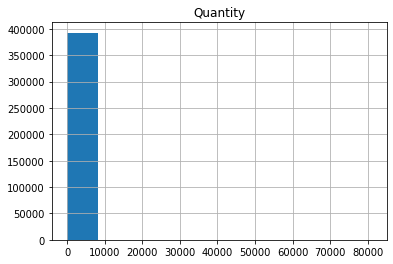

In [10]:
sns.boxplot(x='Quantity', data=df)
print("\n")
df.hist(column='Quantity')

(392729, 8)
14.95
(3723, 8)





array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f49377f12d0>]],
      dtype=object)

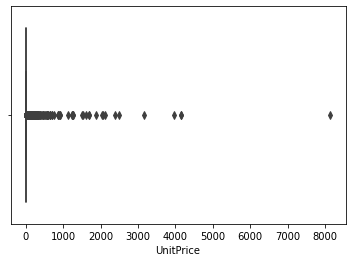

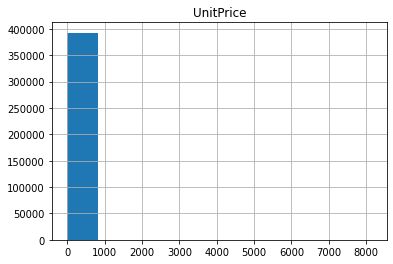

In [18]:
df = df.drop(list(df[df['Quantity']>10000].index), axis=0)
print(df.shape)
print(np.percentile(df['UnitPrice'],[99])[0])
print(df[df['UnitPrice']>np.percentile(df['UnitPrice'],[99])[0]].shape)

sns.boxplot(x='UnitPrice', data=df)
print("\n\n")
df.hist(column='UnitPrice')

In [25]:
'''
Let me tell you the take out from this cell, items at location 144826 and 144828 was bought by the same customer with the same invoice number, at the same time but at different prices
does that make any sense?
makes me feel strange about this "Manual Description"
'''
print(df[df['UnitPrice']>1000].shape)
df[df['UnitPrice']>1000].head()

(21, 8)


InvoiceNo StockCode Description  ...  UnitPrice CustomerID    Country
117054    546328         M      Manual  ...    1687.17    14911.0       EIRE
117055    546329         M      Manual  ...    1687.17    14911.0       EIRE
144826    548813         M      Manual  ...    2382.92    12744.0  Singapore
144828    548813         M      Manual  ...    1252.95    12744.0  Singapore
144829    548820         M      Manual  ...    2053.07    12744.0  Singapore

[5 rows x 8 columns]

In [28]:
df = df.drop(list(df[df['UnitPrice']>1000].index), axis=0)

In [40]:
des = df[df['Description']==df['Description'].str.title()]
#print(des.shape)
#des.head(10)
df = df.drop(list(des.index), axis=0)
print('Dataset shape {} '.format(df.shape))

Dataset shape (392345, 8) 


In [42]:
df.describe()

Quantity      UnitPrice
count  392345.000000  392345.000000
mean       12.721194       2.962478
std        42.942174       5.940544
min         1.000000       0.000000
25%         2.000000       1.250000
50%         6.000000       1.950000
75%        12.000000       3.750000
max      4800.000000     908.160000

**Exploratory Analysis**

In [58]:
df.head()

InvoiceNo StockCode  ... CustomerID         Country
0    536365    85123A  ...    17850.0  United Kingdom
1    536365     71053  ...    17850.0  United Kingdom
2    536365    84406B  ...    17850.0  United Kingdom
3    536365    84029G  ...    17850.0  United Kingdom
4    536365    84029E  ...    17850.0  United Kingdom

[5 rows x 8 columns]

In [59]:
'''
Turns out this dataste wont particularly need much of exploratory analysis
'''
df.corr()

Quantity  UnitPrice
Quantity   1.000000  -0.062079
UnitPrice -0.062079   1.000000

In [77]:
print("number of unique countries {} ".format(df['Country'].nunique()))
print("number of unique customers {} ".format(df['CustomerID'].nunique()))
#px.pie(df, values="CustomerID", names="Country", title="Pie Chart for Customer countries", color_discrete_sequence= px.colors.sequential.RdBu)
# fig = go.Figure(data=[go.Pie(labels=df.Country, values=df.CustomerID, title="Pie Chart for Customer countries", color_discrete_sequence= px.colors.sequential.RdBu)])
# fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))
# fig.show()
px.histogram(df, x="Country")

37
4333


In [86]:
'''
Turns out that most of potential customers in the data given are from the UK, the table below show a 90% from the UK
One could obviously guess the company that recorded the data would definitely be from the UK
'''
List = []
for i in df['Country'].unique():
  per = len(df[df['Country']==i])/len(df)
  List.append("%.4f"%per)

Map = [[a,b] for (a,b) in zip(list(df['Country'].unique()), List)]
showcase_df = pd.DataFrame(np.array(Map), columns=['Countries', 'Percent(%)'])
showcase_df.head()

Countries Percent(%)
0  United Kingdom     0.8892
1          France     0.0212
2       Australia     0.0030
3     Netherlands     0.0060
4         Germany     0.0230

Building the Model